In [431]:
%pylab inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.utils.data
import  torch.optim
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/praateek/miniconda3/envs/ml/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [432]:
class CharRNNDataset(torch.utils.data.Dataset):
    def __init__(self, text, sequence_length):
        self.char_ls = sorted(list(set(text)))
        self.vocab_size = len(self.char_ls)
        self.char_to_int_map = dict(zip(self.char_ls, range(len(self.char_ls))))
        self.int_to_char_map = dict(zip(range(len(self.char_ls)), self.char_ls))
        full_data = np.array(list(map(self.char_to_int_map.get, text)))
        # Truncate slightly so we have a num_chars = num_lines * seq_length
        print("Full data", len(full_data))

        self.num_lines = int(len(full_data) / sequence_length)
        print("Num lines", self.num_lines)
        print("Num lines", self.num_lines * sequence_length)

        full_data = full_data[
            :self.num_lines * sequence_length
        ]

        full_x_data = full_data.copy()
        full_y_data = full_data.copy()
        full_y_data[:-1] = full_data[1:]
        full_y_data[-1] = full_data[0]

        self.x_lines = full_x_data.reshape(self.num_lines, sequence_length)
        self.y_lines = full_y_data.reshape(self.num_lines, sequence_length)
    def __getitem__(self, index):
        x = torch.LongTensor(self.x_lines[index])
        y = torch.LongTensor(self.y_lines[index])
        return x, y

    def __len__(self):
        return self.num_lines


def load_data(input_path, sequence_length, batch_size):
    """ Load data and get Dataset and Dataloader """
    with open(input_path, "r", encoding="utf-8") as f:
        data = f.read()

    dataset = CharRNNDataset(text=data, sequence_length=sequence_length)
    vocab_size = dataset.vocab_size
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=1)
    return vocab_size, dataset, dataloader


In [433]:
def repackage_hidden(h):
    """Repackages a hidden state as a new variable. The stops gradients
    from flowing back further."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
def new_hidden(model, batch_size):
    """Get a new hidden variable"""
    return repackage_hidden(model.init_hidden(batch_size))


In [434]:
class CharRNNModel(nn.Module):
    def __init__(self, num_layers, rnn_size, vocab_size):
        super(CharRNNModel, self).__init__()

        # Parameters
        self.num_layers = num_layers
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        # Layers (containing weights)
        self.embedding = nn.Embedding(
            self.vocab_size, self.rnn_size,
        )


        self.rnn = nn.RNN(
            self.rnn_size,
            self.rnn_size,
            self.num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(self.rnn_size, self.vocab_size)

    def forward(self, x, hidden):
        """
        Inputs come in with dimensions (from data loaders):
            [batch_size, seq_length]
        """

        # Embed
        embedded = self.embedding(x)
    
        # Push through RNN
        lstm_out, hidden = self.rnn(embedded, hidden)

        # Apply Linear layer
        output = self.fc1(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden weights"""
        weight = next(self.parameters()).data
        h = Variable(
            weight.new(self.num_layers, batch_size, self.rnn_size).zero_()
        )
        return h
    
def train(x, y, model, criterion, optimizer, h):
    model.zero_grad()
    model.train()
    output, h = model(x, h)
    loss = criterion(output.contiguous().view(-1, vocab_size), y.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    return loss.data.cpu().numpy()[0], h

def evaluate(model, h, seed, sequence_length):
    model.eval()
    seed_text = np.array(list(map(dataset.char_to_int_map.get, seed))).reshape(1, -1)
    history = seed_text
    for i in range(5):
        predicted_input = history[:, -sequence_length:]
        predicted_input_var = Variable(torch.LongTensor(predicted_input))
        output, h = model(predicted_input_var, h)
        history = np.hstack((history,np.argmax(torch.exp(output).data.numpy()[0], 1).reshape(1,-1)))
    return history

def sample(model, size=100, seed='The', top_k=None, cuda=False):
    """ Sample characters from the model.
    """

    model.eval()
    seed_text = np.array(list(map(dataset.char_to_int_map.get, seed))).reshape(1, -1)
    list_ = seed_text.reshape(-1)
    h = model.init_hidden(1)
    char, h = model(Variable(torch.LongTensor(seed_text)), h)
    new_char = torch.max(F.softmax(char, dim=2)[:,2,:],1)[1]
    list_ = seed_text.tolist()[0]
    for i in range(100):
        list_.append(new_char.data.view(1)[0])
        new_char, h = model(new_char.view(1,1), h)
        new_char = torch.max(F.softmax(new_char, dim=2),2)[1]
    return (''.join(list(map(dataset.int_to_char_map.get, list_))))
#     chars.append(char)

#     for ii in range(size):
#         char, h = model.predict(chars[-1], h, cuda=cuda, top_k=top_k)
#         chars.append(char)

#     return ''.join(chars)


def sample(model, size=100, prime='The', top_k=None, cuda=False):
    """ Sample characters from the model.
    """

    model.eval()
    chars = []
    h = model.init_hidden(1)
    for ch in prime:
        seed_text = Variable(torch.LongTensor(np.array(list(map(dataset.char_to_int_map.get, ch))).reshape(1, -1)))
        h = Variable(h.data)
        output, h = model(seed_text, h)
        p = F.softmax(output, dim = 2).data
        top_ch = np.arange(dataset.vocab_size)
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        chars.append(char)
    for ii in range(size):
        seed_text = Variable(torch.LongTensor(np.array(chars[-1]).reshape(1, -1)))
        h = Variable(h.data)
        output, h = model(seed_text, h)
        p = F.softmax(output, dim = 2).data
        top_ch = np.arange(dataset.vocab_size)
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        chars.append(char)
    return (''.join(list(map(dataset.int_to_char_map.get, chars))))


In [435]:
sample(model)

'he greary, a at\nposery of here\npicthe carm Barching to\nknow he had.\n\nNatasha had rusope.\n\nNater peaher '

In [436]:
epochs = 10
hidden_units = 100
batch_size = 14
vocab_size, dataset, dataloader = load_data("warpeace_input.txt", sequence_length=25, batch_size=batch_size)
model = CharRNNModel(num_layers=1, rnn_size=hidden_units, vocab_size=vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)
losses = []


Full data 3196213
Num lines 127848
Num lines 3196200


In [ ]:
for epoch in range(epochs):
    h = model.init_hidden(14)
    counter = 0
    batch_loss = 0
    for x, y in dataloader:
        counter += 1
        x_var, y_var = Variable(x), Variable(y)
        this_batch_size = x_var.size()[0]
        h = Variable(h.data)
        loss_val, h = train(x_var,y_var, model, criterion, optimizer, \
                           h=h)
        batch_loss += loss_val/this_batch_size
        
        if counter % 1000 == 0:
            prediction = sample(model)
#             prediction = evaluate(model, new_hidden(model, batch_size=1), 'The ', sequence_length)
            print(epoch, counter, loss_val, prediction)
    losses.append(batch_loss)
        

0 1000 1.5897549 han the spcher of histolashed in
less of all with assock of gry to half he said his latted andy
seched.
0 2000 1.6549367 he came," shistov pust on that intrancarm Boate, advant how gone up yet is
be kison bles we fleare digh
0 3000 1.6002694 oa dooreaty around his guante lift you.

One warmatioul, but his lont to the gresperili, it. He has bee
0 4000 1.6302135 he nearing on themseld have rightly Prince Vas that
impin
" the old being thim. Having at acros hegs? D
0 5000 1.7124991 ha oppresstry the
woorwd. He e"on.
As who had not sawe trew that I
mountrev in Raced.

Dn ondles, but t
0 6000 1.6285071 ha read it's servemested at the cart chieflomperiesting were sheace, the decisived as evenervisandy wer
0 7000 1.7972686 ha prepitatiate. And in."

Is a!" said at a but can admill.

If been onen drack obbed pleason... Thy. B
0 8000 1.686118 ha expleade yam sudden, he campa at Brong which have cad fries' Now, awasont of thind
sethe doing its m
0 9000 1.7392954 he legan
you sur

7 6000 1.6632835 he feelies swith in voice esplatching of the come all and see them
sever up," he stayarch crow, y--mood
7 7000 1.6881416 hire would father is buglof in the lation his
puring," said Rostov: He had bud. "After read ve, flancl.
7 8000 1.769745 hen feness, never. Deatisfined and fine was
youngen there, and had ng it the sile othin and full
till t
7 9000 1.608826 hi possuto an more Plated of a soce the French
he scopped loved of his. Pierre or
Natasha he
is five on
8 1000 1.712978 here pring to his lod
clong at down susmench place mordendly beaute
didesoped an alway,
nuture aiming t
8 2000 1.6873978 hen
the taken
on the girl understangen, and strery" of can carcadehereigs, third with my es, and adder,
8 3000 1.696944 hare and one
murs docist difficult, to
ran-way..." 'Madry you showing Bremaid slarch and surple
decking
8 4000 1.8148706 he mosoce the
valeadvis' band! With that facton fro's went down he all
no remy wish it's he while the m
8 5000 1.6543353 ha seeloson's flumc

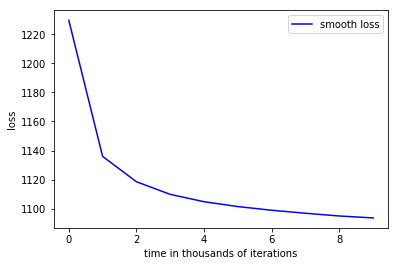

In [438]:
plt.plot(range(len(losses)), losses, 'b', label='smooth loss')
plt.xlabel('time in thousands of iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [35]:
np.asarray([45,59,56,59,56, 1, 59]).shape

(7,)

In [ ]:
eval(model, model.init_hidden(1), 'The')

In [58]:
losses

[]

In [62]:
print(len(dataset))

127848
